In [45]:
import os 
cwd = os.getcwd()
import sys
sys.path.append("C:/Users/gomel/Documents/global_python_codes/Metrics_thresholds_boots") # go to parent dir

sys.path.append("C:/Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter") # go to parent dir
import sde_analysis as sa

import sympy as sp
import ewstools as ews
import numpy as np
import sdeint
import metrics
import boots as bts
import scipy.stats as st
import astropy.stats as astrost
import scipy.signal as sg
from scipy import special

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"    
})
import matplotlib.lines as lines
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

from sympy import lambdify

try:
    os.mkdir('./timescales')
except: print('Folder exists')

c1=(221/256,170/256,51/256)
c2=(187/256,85/256,102/256)
c3=(0,68/256,136/256)
cols=(c1,c2,c3)

Folder exists


This is a simulation of a onlinear equation with aditive noise using a Heun method where the noise only applies on the variable and not the parameter. 

\begin{equation}
\dot{x}=\lambda  x-x^3
\end{equation}


In [46]:
xs, ls = sp.symbols('xs lambda')
eq=(ls*(xs)-(xs)**3)
M=ls-3*xs**2
sp.solve(eq, xs)


[0, -sqrt(lambda), sqrt(lambda)]

In [47]:
sol1=sp.sqrt(ls)
sp_dxdl=sp.diff(sol1,ls)

Mr=M.subs(xs, sol1)
M1=M.subs(xs, 0)

In [48]:
Mr

-2*lambda

In [49]:
M1

lambda



### Characteristic time-scale exploration

First we do a deterministic integration to estimate the time-scale of the transition.

In [50]:
l0=-1.2
lf=1.2
cls=0.0003
cl=np.sign(lf-l0)*cls
s=0.01


adiab=sp.solve(-2*M1*ls/cl+1, ls)
adiab=sp.N(adiab[0]) 
ad1 = lambdify([ls],-2*M1*ls/cl+1)

adiab2=sp.solve(-M1*ls/cl+1, ls)
adiab2=sp.N(adiab2[0]) 
ad2 = lambdify([ls],-M1*ls/cl+1)
adiab3=sp.solve(-M1*ls/cls+10, ls)
adiab3=sp.N(adiab3[0]) 
M1l = lambdify([ls],M1)
adiab_cl=sp.solve(-M1*ls/cls+3, ls)
adiab_cl=sp.N(adiab_cl[0]) 


t_final=(lf-l0)/cl
t_rm=np.abs(1/M1l(lf))
t_threshold=t_rm/2
dt=t_threshold/4
t_win=t_rm/dt ### length of correlation. 
    
datalen=t_final/(600*7*10)
if datalen>=t_threshold/4: 
    datalen=t_threshold/4
    
tspan=np.arange(0,t_final,datalen)
print(r'$\Delta t= $', tspan[1]-tspan[0], 't_final:', t_final)
print('correlation time: ', t_win)
print('data length: ', len(tspan))
print('dot lambda: ', cl)
if l0<0:
    x0 = np.array([0.])
else:
    x0 = np.array([np.sqrt(l0)])
 #       x0= np.array([0.]) 

def f(x, t):
    #X=x[0]. dot(x)=r(x-2)*(x-1)*(x-3)
    #r=x[1]. dot(r)=cte.  This is a constant swipe of parameter r at speed dot(r). 
#    A=np.array([x[1]*x[0]+x[0]**3-x[0]**5,-2*r0/t_final*special.erf(x[1]) ])
    l=l0+cl*t
    A=np.array([(l*(x[0])-(x[0])**3)])
    return A

def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([s]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B
np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.
l_var=np.linspace(lf,l0,20)
l=l0+cl*tspan
dl=cl*tspan[1]-l0


result = sdeint.stratHeun(f, G, x0, tspan)
print('Integration DOOONNEE')


$\Delta t= $ 0.10416666666666667 t_final: 8000.0
correlation time:  8.0
data length:  76800
dot lambda:  0.0003
Integration DOOONNEE


In [51]:
adiab=sp.solve(-2*M1*(ls)/cls+1, ls)
adiab=sp.N(adiab[0]) 
adiab

-0.0122474487139159

In [52]:
adiab2

-0.0173205080756888

In [53]:
adiab3=sp.solve(-M1*(ls)/cls+10, ls)
adiab3=sp.N(adiab3[0]) 
adiab3

-0.0547722557505166

In [54]:
adiab_cl

-0.0300000000000000

1207.136092495618

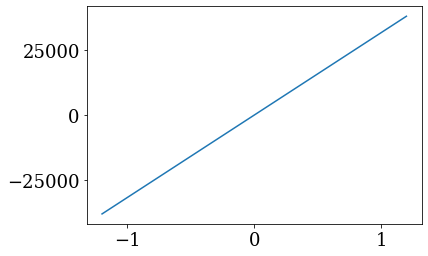

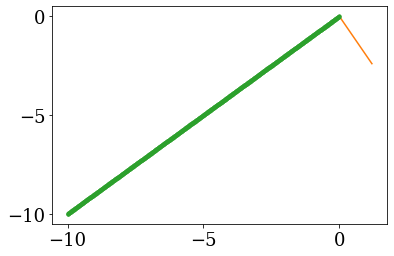

In [55]:

fig=plt.figure()
plt.plot(l,t_drift)
fig=plt.figure()
plt.plot(l[l<0],M1_fun(l[l<0]))
plt.plot(l[l>0],Mr_fun(l[l>0]))
plt.rc('font',size=25)


bif_idx=np.abs(0-l).argmin()
slow_idx=np.abs(adiab3-l).argmin()

fast_window=bif_idx-slow_idx
fast_window
adiab3

M_fun= lambdify([ls],M1)
lvars=np.linspace(-10,0,1000)
plt.plot(lvars,M_fun(lvars),'.')


t_adiab=-1/np.real(M_fun(complex(left_adiab)))
t_adiab/dt


In [74]:
from importlib import reload
reload(sa)


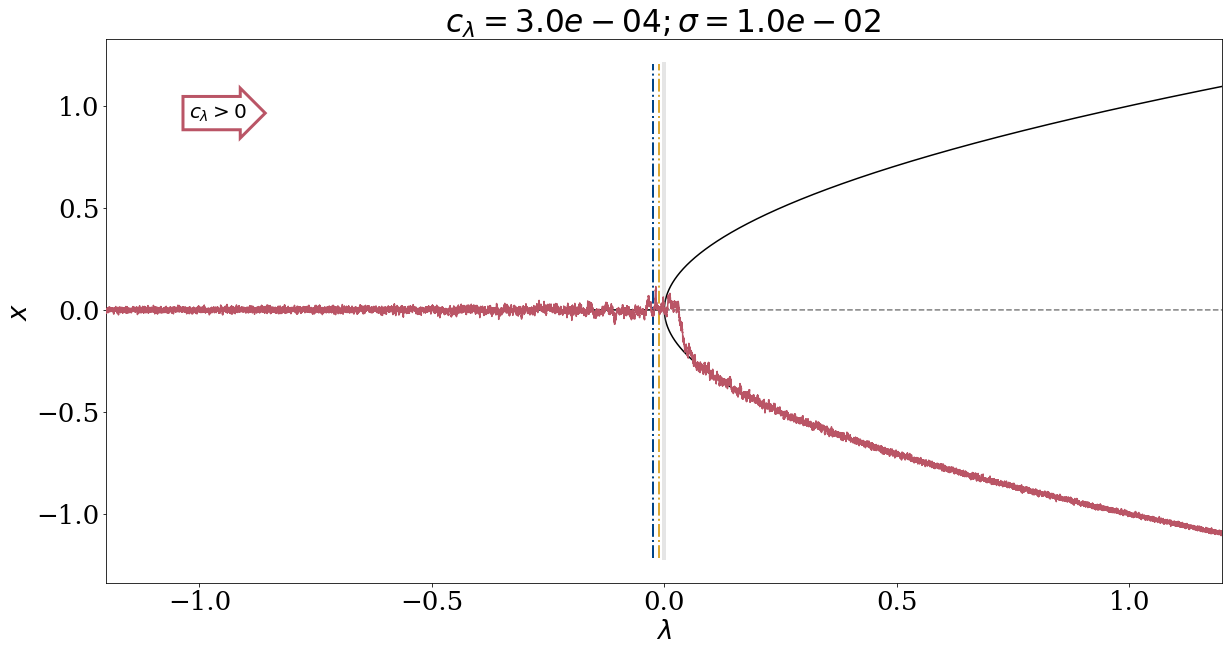

In [75]:

fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
plt.plot(l,result[:,0],color=c2,zorder=9)
plt.plot(l[l>0],np.sqrt(l[l>0]),'-k',alpha=1)
plt.plot(l[l>0],-np.sqrt(l[l>0]),'-k',alpha=1)
plt.plot(l[l<0],0*l[l<0],'-k',alpha=1)
plt.plot(l[l>0],0*l[l>0],'--k',alpha=0.5)
ylim=ax.get_ylim()
ax.plot([0,0],ylim,'-',color='gray',lw=4,alpha=0.2)
ax.set_xlim(np.min(l),np.max(l))

xlim=ax.get_xlim()
ax.plot([adiab,adiab],ylim,'-.',linewidth=2,color=c1,alpha=1,label='tracking')

xi_f1_left=sp.solve(2-ls**2/(ls**2-cl), ls)
left_adiab=sp.N(xi_f1_left[0])

#ax.plot([adiab3,adiab3],ylim,'-.',linewidth=2,color=c3,alpha=1,label='tracking')
ax.plot([left_adiab,left_adiab],ylim,'-.',linewidth=2,color=c3,alpha=1,label='tracking')
#lt.plot(result[result[:,1]>0,1],result[result[:,1]>0,0],'r')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$x$')
plt.rc('font',size=26)


if np.sign(cl)<0:
    t = ax.text(
        xlim[1]*0.8, 0.8*ylim[1], "$c_\lambda<0$", ha="center", va="center", rotation=0, size=20,
        bbox=dict(boxstyle="larrow,pad=0.3",fc="white", ec=c2, lw=3))
else:
    t = ax.text(
    xlim[0]*0.8, 0.8*ylim[1], "$c_\lambda>0$", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="rarrow,pad=0.3",fc="white", ec=c2, lw=3))
ax.set_title(r'$c_\lambda=%.1e ; \sigma=%.1e $ '%(cl,s))
fig.savefig('./bifurcation_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI



#### Integration scheme: 

Here I use the sdeint python package to integrate based on the Heun scheme. This decision is based on the paper "Integration of stochastic differential equations on a computer" from R.Manella.
DOI: 10.1142/S0129183102004042


Here i do a set of 'n' runs to do statististics on: 

## Detrended

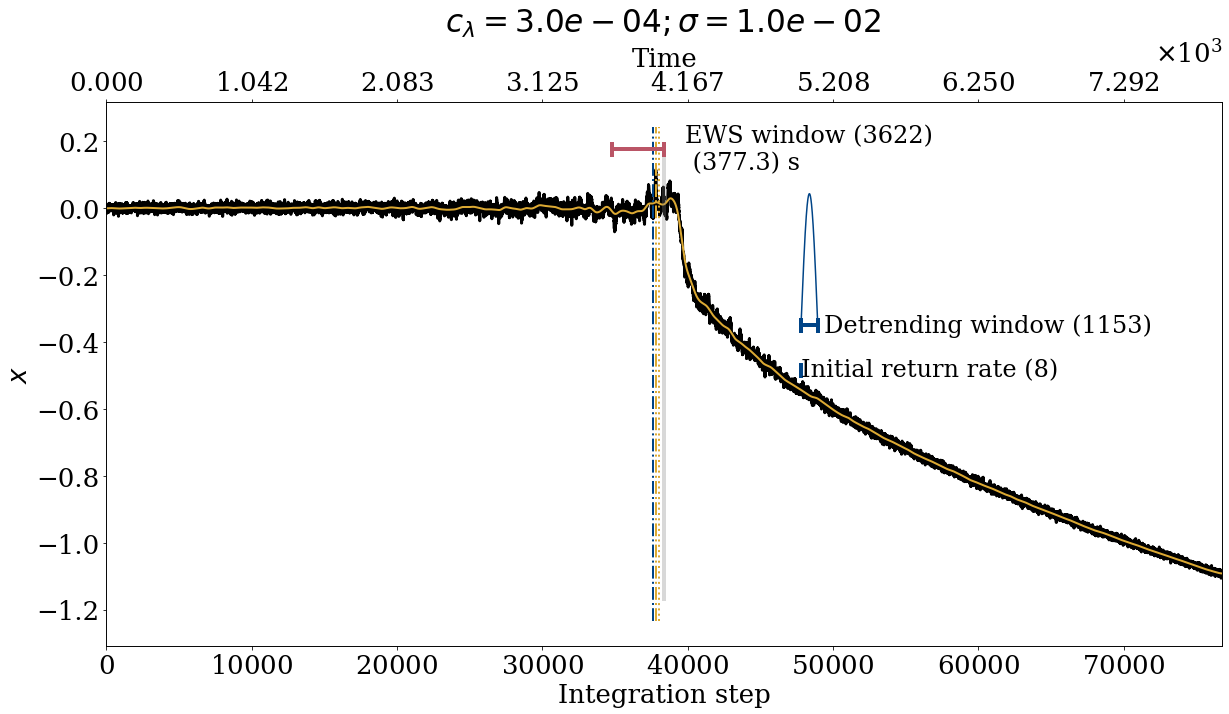

In [76]:
from scipy import signal
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

bootstrapping=False
smoothing=True


bif_idx=np.abs(0.-l).argmin()
adiab_idx=np.abs(adiab-l).argmin()
adiab2_idx=np.abs(adiab2-l).argmin()
#adiab3_idx=np.abs(adiab3-l).argmin()
adiab3_idx=np.abs(left_adiab-l).argmin()

trans=bif_idx
res=result[:,0]
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t


varwin=np.int64(15*t_win/dt+1)
ewswin=np.int64(3*np.int64(t_adiab/dt)+1)
ts = ews.TimeSeries(data=res)  ### ews stats ### 

bw=varwin/2
if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(20,10))

    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    plt.xlim(t[0],t[-1])
    sa.plot_detrend(fig, ewswin,varwin,t_rm,dt,bw,trans)

ax.set_title(r'$c_\lambda=%.1e ; \sigma=%.1e $ '%(cl,s))

ylim=ax.get_ylim()

plt.rc('font',size=26)


ax.plot([adiab_idx,adiab_idx],ylim,':',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab2_idx,adiab2_idx],ylim,'-.',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab3_idx,adiab3_idx],ylim,'-.',linewidth=2,color=c3,alpha=1,label='Bifurcation')
ax.xaxis.set_major_formatter(formatter) 
xtik=ax.get_xticks()
ax2 = ax.twiny()
ax2.set_xlim([0,tspan[-1]])
ax2.xaxis.set_major_formatter(formatter) 
ax2.set_xticks(xtik[:-1]*dt)
ax2.set_xlabel('Time')
fig.savefig('./detrend_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI


#add windows and detrending information as an annotation

In [37]:
t_adiab=-1/np.real(M1l(complex(left_adiab)))
t_adiab/dt

1207.136092495618

In [65]:
xtik*dt

array([   0.        , 1041.66666667, 2083.33333333, 3125.        ,
       4166.66666667, 5208.33333333, 6250.        , 7291.66666667,
       8333.33333333])

In [38]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin,sm=smoothing)


if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


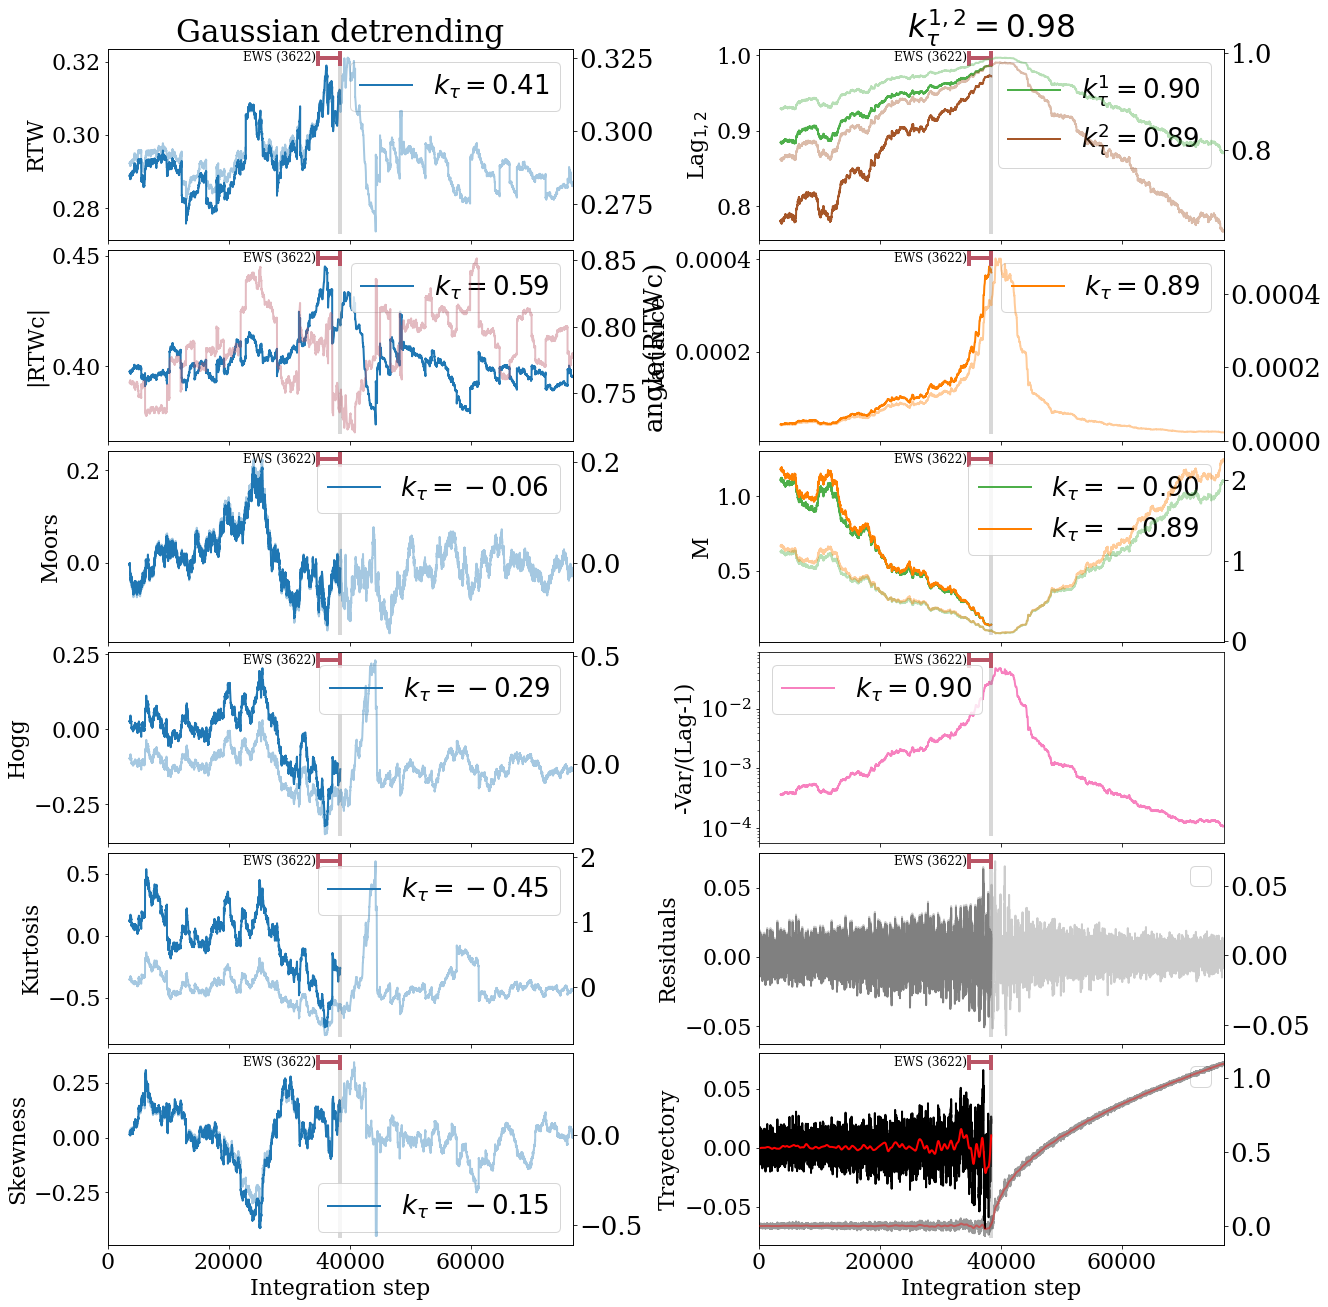

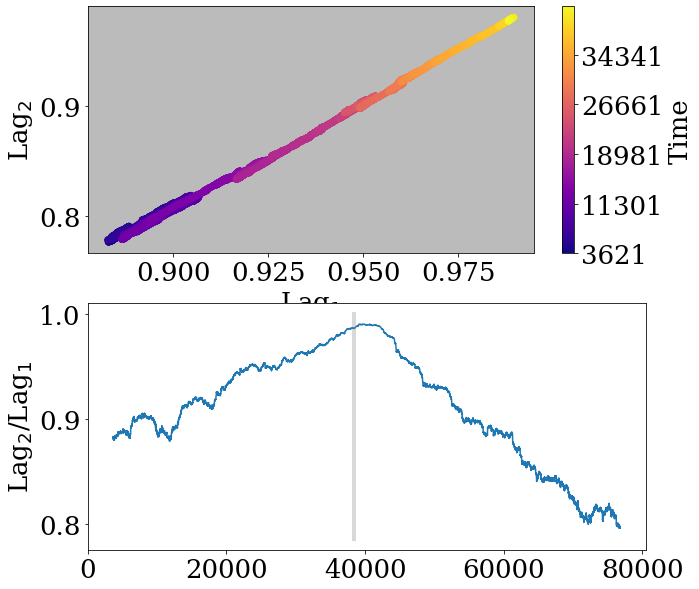

In [39]:
fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./Gdet_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI
fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

## Non detrended data:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


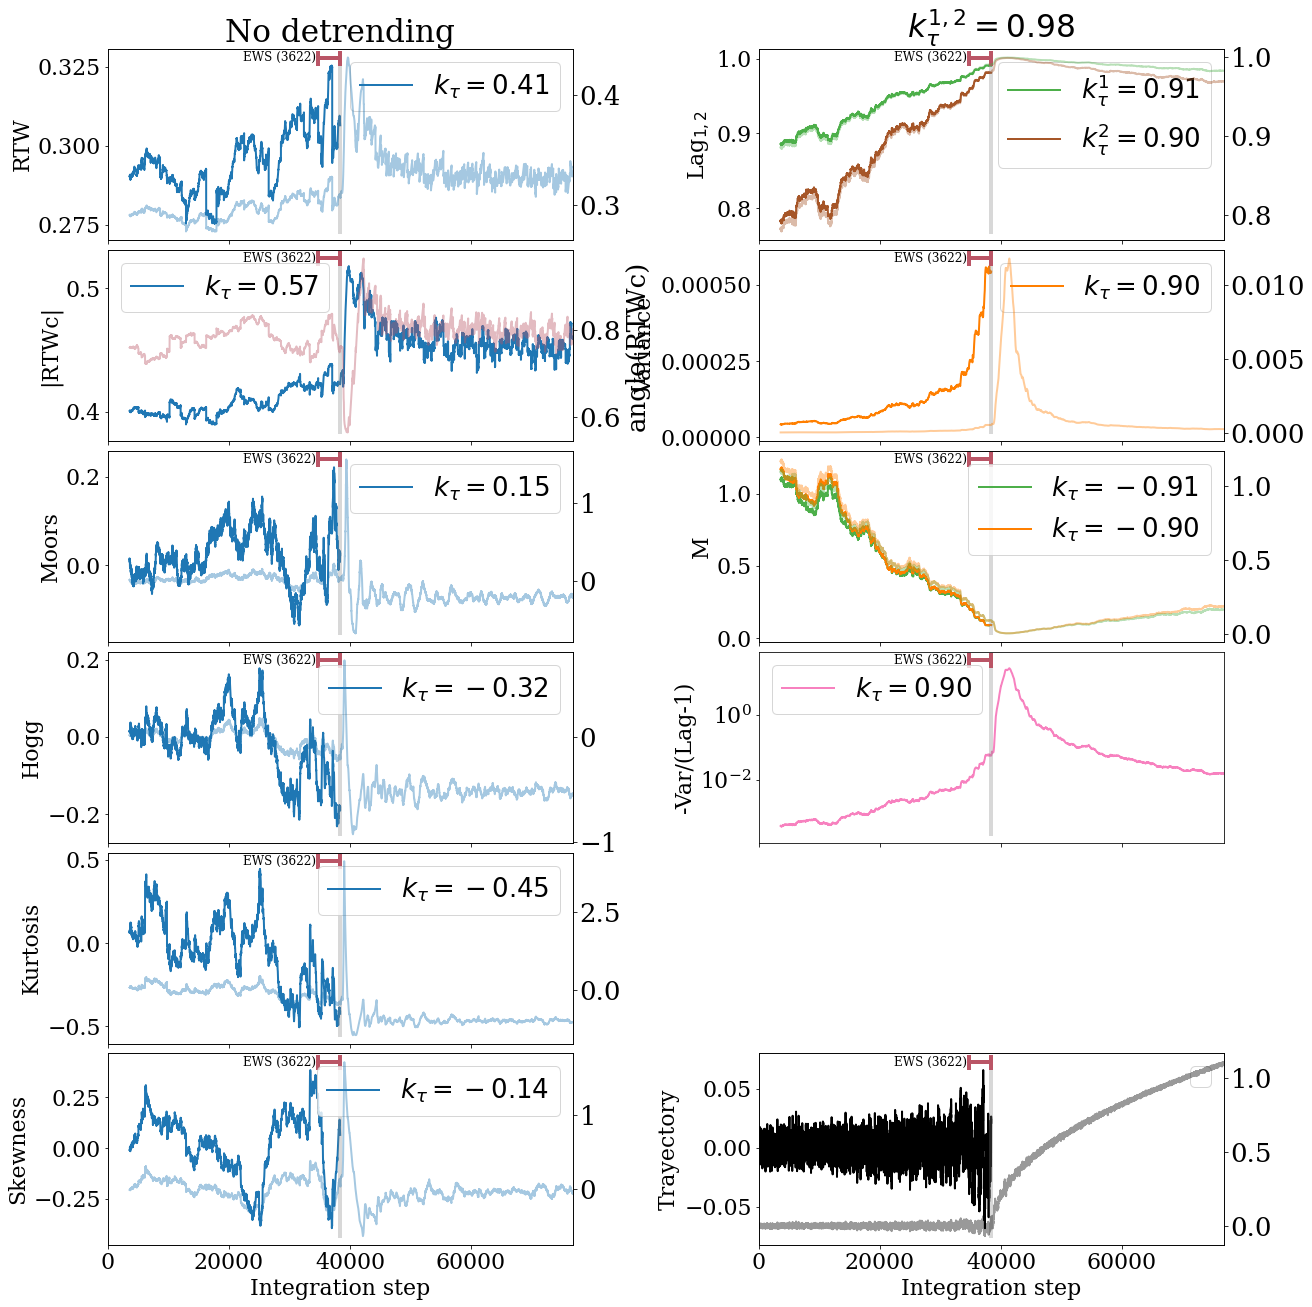

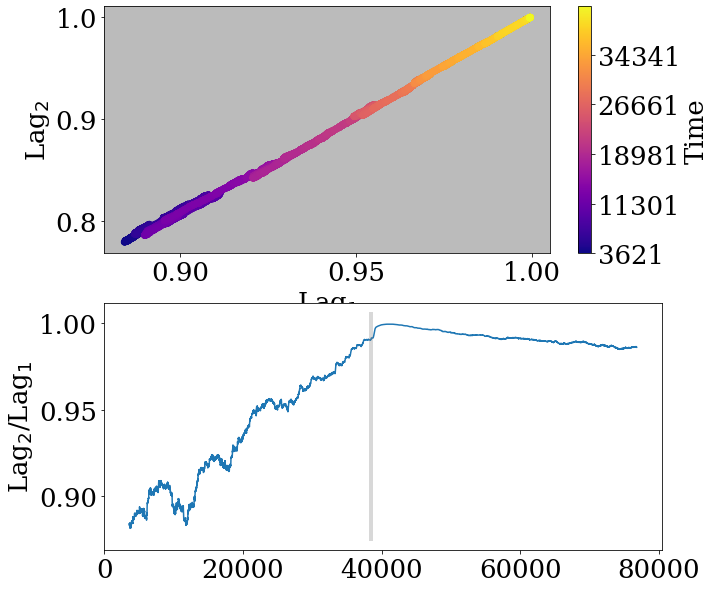

In [40]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./No_det_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI
fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

To do: 

- implement WOTAN package detrending
- fix bootstraping

 vr_b = bts.boot_result(bts.blockbootstrap(np.var,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    var[j]= vr_b[0]
    var_b[j]=vr_b[1][0],vr_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.skew,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    skew[j]= sk_b[0]
    skew_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(np.mean,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    mean[j]= sk_b[0]
    mean_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.kurtosis,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    kur[j]= sk_b[0]
    kur_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(metrics.RTW_max,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    RTW[j]= sk_b[0]
    RTW_b[j]=sk_b[1][0],sk_b[1][1]
    try:
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.kr2,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        kr2[j]= sk_b[0]
        kr2_b[j]= sk_b[1][0],sk_b[1][1]
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.kr3,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        kr3[j]= sk_b[0]
        kr3_b[j]= sk_b[1][0],sk_b[1][1]
    except:
        continue

Integration DOOONNEE


NameError: name 'm_inest_1' is not defined

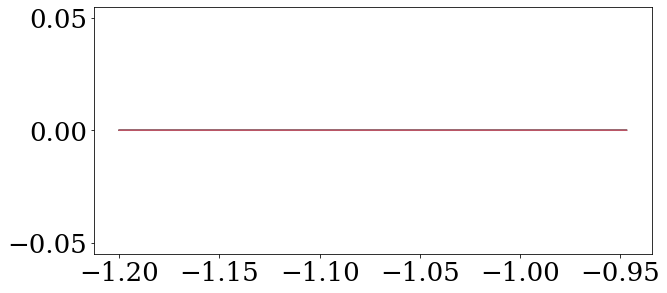

In [42]:
def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([s*x[0]]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B
np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.
l_var=np.linspace(lf,l0,20)
l=l0+cl*tspan
dl=cl*tspan[1]-l0


result2 = sdeint.stratHeun(f, G, x0, tspan)
print('Integration DOOONNEE')

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(l,result2[:,0],color=c2,zorder=10)
plt.plot(l[l>-0.25],np.sqrt(1/2)*np.sqrt(1+np.sqrt(1+4*l[l>-0.25])),'-',color='black')
plt.plot(l[l<0],0*l[l<0],'-k')
plt.plot(l[l>0],0*l[l>0],'--k',alpha=0.5)
plt.plot(l[(l<0) & (l>-0.25)],m_inest_1(l),'--k',alpha=0.5)

#lt.plot(result[result[:,1]>0,1],result[result[:,1]>0,0],'r')
plt.xlabel(r'$\lambda$')
plt.ylabel('$x$')
plt.subplot(212)
plt.plot(tspan,l,color=c1,lw=2)
plt.xlabel('t')
plt.ylabel(r'$\lambda$')
#print('$\dot{r}$: ',dot_r,(result[2,1]-result[1,1])/(tspan[2]-tspan[1]) )
print('$dt$: ',tspan[2]-tspan[1])


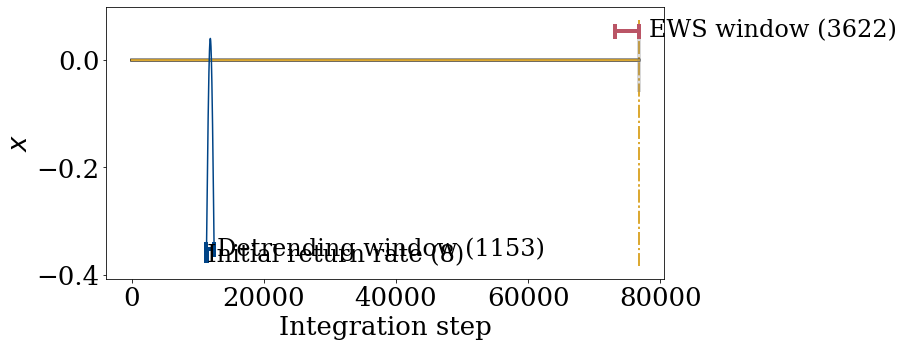

In [43]:
from scipy import signal

bootstrapping=False
smoothing=True

bif_idx=np.abs(0.-l).argmin()

trans=bif_idx
res=result2[:,0]
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t
adiab_idx=np.abs(adiab-l).argmin()
adiab2_idx=np.abs(adiab2-l).argmin()


ts = ews.TimeSeries(data=res)  ### ews stats ### 

if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    
    sa.plot_detrend(fig, ewswin,varwin,t_rm,dt,bw,trans)
ylim=ax.get_ylim()
ax.plot([adiab_idx,adiab_idx],ylim,':',linewidth=2,color=c1,alpha=1,label='Bifurcation',zorder=0)
ax.plot([adiab2_idx,adiab2_idx],ylim,'-.',linewidth=2,color=c1,alpha=1,label='Bifurcation',zorder=0)


In [ ]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin,sm=smoothing)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])


In [ ]:

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./Gdet_multiplicative.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI
fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

## not detrended data

In [ ]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
data=res

if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=0.01, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals
    fig=plt.figure(figsize=(10,5))
    plt.plot(t,res)
    plt.plot(t,smooth)
    
    
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./No_det_multiplicative.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI


In [ ]:
#cambiar kr2 por moors, pasar s como argument, o s*x

In [ ]:

fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

In [ ]:


hogg2_b=np.zeros([len(tidx),2])
hogg2b=np.zeros([len(tidx)])
n_resample_case=500 #Bootstraping re-samples
sample_perc=70 #Bootstraping percentile
sk_b = [bts.boot_result(bts.blockbootstrap(metrics.Hogg2,data[j:tidx[j]],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j  in  range(len(tidx))]




In [ ]:
tb=tidx[::np.int64(len(tidx)/2000)]

In [ ]:
len(tb)

In [ ]:
hogg2_b=np.zeros([len(tb),2])
hogg2b=np.zeros([len(tb)])
n_resample_case=10 #Bootstraping re-samples
sample_perc=70 #Bootstraping percentile
sk_b = [bts.boot_result(bts.blockbootstrap(metrics.Hogg2,data[j:tb[j]],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j  in  range(len(tb))]


hogg2_b=np.zeros([len(tb),2])
hogg2_b[:,0]=[sk_b[j][1][0] for j  in  range(len(tb))]
hogg2_b[:,1]=[sk_b[j][1][1] for j  in  range(len(tb))]



In [ ]:
fig=plt.figure(figsize=(20,20))
plt.plot(tidx,hogg2,'b',alpha=0.6)
plt.plot(tb,hogg2b,'b')
plt.fill_between(tb, hogg2_b[:,0], hogg2_b[:,1], color=CB_color_cycle[0], alpha=.4)

plt.plot([bif_idx,bif_idx],ylim,'-',linewidth=4,color='gray',alpha=0.3)


In [ ]:
mr_b=np.zeros([len(tb),2])
mrb=np.zeros([len(tb)])
n_resample_case=10 #Bootstraping re-samples
sample_perc=70 #Bootstraping percentile
sk_b = [bts.boot_result(bts.blockbootstrap(metrics.Moors,data[j:tb[j]],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j  in  range(len(tb))]


mrb=[sk_b[j][0] for j  in  range(len(tb))]
mr_b[:,0]=[sk_b[j][1][0] for j  in  range(len(tb))]
mr_b[:,1]=[sk_b[j][1][1] for j  in  range(len(tb))]



In [ ]:
mrb=[sk_b[j][0] for j  in  range(len(tb))]
mr_b[:,0]=[sk_b[j][1][0] for j  in  range(len(tb))]
mr_b[:,1]=[sk_b[j][1][1] for j  in  range(len(tb))]

fig=plt.figure(figsize=(20,20))
plt.plot(tidx,moors,'b',alpha=0.6)
plt.plot(tb,mrb,'b')
plt.fill_between(tb, mr_b[:,0], mr_b[:,1], color=CB_color_cycle[0], alpha=.4)

plt.plot([bif_idx,bif_idx],ylim,'-',linewidth=4,color='gray',alpha=0.3)
plt.ylim([-1,3])

In [ ]:
ewswin

In [ ]:
len(res)/2000

In [ ]:
fig=plt.figure(figsize=(20,9))
plt.plot(r1,var1,'b',linewidth=3)
plt.plot(r2,var2,'r',linewidth=2)
plt.plot(r1[r1>-0.25],m_sol1(r1),'-',color='k')
plt.plot(r1[(r1<0) & (r1>-0.25)],m_inest(r1),'--',color='k')
plt.plot(r1[r1<0],0*r1[r1<0],'-',color='k')
plt.plot(r1[r1>-0.25],-m_sol1(r1),'-',color='k')
plt.plot(r1[(r1<0) & (r1>-0.25)],-m_inest(r1),'--',color='k')
plt.xlabel('r',fontsize=16)
plt.ylabel('x',fontsize=16)
plt.xlim([-1,1])
right_inset_ax = fig.add_axes([.16, .2, .4, 9/20*0.4])
right_inset_ax.plot(r1,var1,'b',linewidth=3)
right_inset_ax.plot(r2,var2,'r',linewidth=2)
right_inset_ax.plot(r1[r1>-0.25],m_sol1(r1),'-',color='k')
right_inset_ax.plot(r1[(r1<0) & (r1>-0.25)],m_inest(r1),'--',color='k')
right_inset_ax.plot(r1[r1<0],0*r1[r1<0],'-',color='k')
right_inset_ax.plot(r1[r1>-0.25],-m_sol1(r1),'-',color='k')
right_inset_ax.plot(r1[(r1<0) & (r1>-0.25)],-m_inest(r1),'--',color='k')
right_inset_ax.set_xlabel('r')
right_inset_ax.set_ylabel('x')
right_inset_ax.set_xlim([-3,3])
#right_inset_ax.set_xlim([-1,1])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Timescales

In [ ]:
bif_idx=np.abs(0-l).argmin()
slow_idx=np.abs(adiab3-l).argmin()

fast_window=bif_idx-slow_idx
fast_window
adiab3

M_fun= lambdify([ls],M1)
lvars=np.linspace(-10,0,1000)
plt.plot(lvars,M_fun(lvars),'.')


t_adiab=-1/np.real(M_fun(complex(adiab)))
t_adiab/dt